In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install Prophet  
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#read csv
df = pd.read_csv('selected_esp500_esg.csv')

## Data Exploration

In [3]:
#quick data exploration
df.head()

,Date,Ticker,Close,High,Low,Open,Volume,Return,Total ESG Risk score
0,2023-10-31,ADM,66.630394,67.049333,66.379032,66.593154,2627000.0,NaN,31.8
1,2023-11-01,ADM,66.444206,67.254156,66.304557,66.891074,2516300.0,-0.002794,31.8
2,2023-11-02,ADM,67.421730,67.579995,66.211457,66.500060,2547300.0,0.014712,31.8
3,2023-11-03,ADM,67.877907,68.613376,67.701018,68.008244,2330800.0,0.006766,31.8
4,2023-11-06,ADM,67.552071,68.306171,67.440357,67.877920,2911100.0,-0.004800,31.8


In [4]:
df.tail()

,Date,Ticker,Close,High,Low,Open,Volume,Return,Total ESG Risk score
9533,2025-10-24,VLO,171.050003,176.220001,170.800003,174.220001,2352900.0,-0.012014,32.6
9534,2025-10-27,VLO,174.350006,174.419998,169.779999,171.479996,2614200.0,0.019293,32.6
9535,2025-10-28,VLO,169.339996,173.160004,169.300003,172.970001,1708100.0,-0.028735,32.6
9536,2025-10-29,VLO,170.660004,172.050003,167.179993,168.830002,1569800.0,0.007795,32.6
9537,2025-10-30,VLO,170.100006,173.800003,169.020004,170.240005,1848900.0,-0.003281,32.6


In [5]:
df.shape

(9538, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  9538 non-null   object 
 1   Ticker                9538 non-null   object 
 2   Close                 9538 non-null   float64
 3   High                  9538 non-null   float64
 4   Low                   9538 non-null   float64
 5   Open                  9538 non-null   float64
 6   Volume                9538 non-null   float64
 7   Return                9519 non-null   float64
 8   Total ESG Risk score  9538 non-null   float64
dtypes: float64(7), object(2)
memory usage: 670.8+ KB


## Cleaning and Preprocessing

In [8]:
#drop missing values
df_clean = df.dropna().copy()

In [9]:
#categorize stocks by esg risk score
esg_threshold = df_clean['Total ESG Risk score'].mean()

#create column risk group, map low risk if risk tot esg risk score < mean else high risk
df_clean['Risk_Group'] = df_clean['Total ESG Risk score'].apply(
    lambda x: 'Low_Risk_ESG' if x < esg_threshold else 'High_Risk_ESG'
)

print("Risk Group Counts:")
print(df_clean['Risk_Group'].value_counts())

Risk Group Counts:
Risk_Group
High_Risk_ESG    5010
Low_Risk_ESG     4509
Name: count, dtype: int64


In [10]:
#dtypes
print(df_clean.dtypes)

Date                     object
Ticker                   object
Close                   float64
High                    float64
Low                     float64
Open                    float64
Volume                  float64
Return                  float64
Total ESG Risk score    float64
Risk_Group               object
dtype: object


## Summary Stats

In [12]:
#for numerical columns:
df_clean[['Close', 'Volume', 'Return', 'Total ESG Risk score']].describe()

,Close,Volume,Return,Total ESG Risk score
count,9519.000000,9.519000e+03,9519.000000,9519.000000
mean,130.355380,3.036487e+06,0.000829,23.136842
std,97.454446,2.095179e+06,0.018831,10.933682
min,23.087095,3.100000e+05,-0.241971,10.700000
25%,67.854404,1.828500e+06,-0.007915,11.600000
50%,101.110374,2.572900e+06,0.001002,30.500000
75%,149.658951,3.636700e+06,0.009772,32.900000
max,550.544312,5.098340e+07,0.262130,37.300000


In [13]:
#for return by risk group:
df_clean.groupby('Risk_Group')['Return'].describe().T

Risk_Group,High_Risk_ESG,Low_Risk_ESG
count,5010.000000,4509.000000
mean,0.000904,0.000746
std,0.019271,0.018331
min,-0.241971,-0.177211
25%,-0.008195,-0.007662
50%,0.000991,0.001011
75%,0.010276,0.009216
max,0.262130,0.191121


## Exploratory Plots

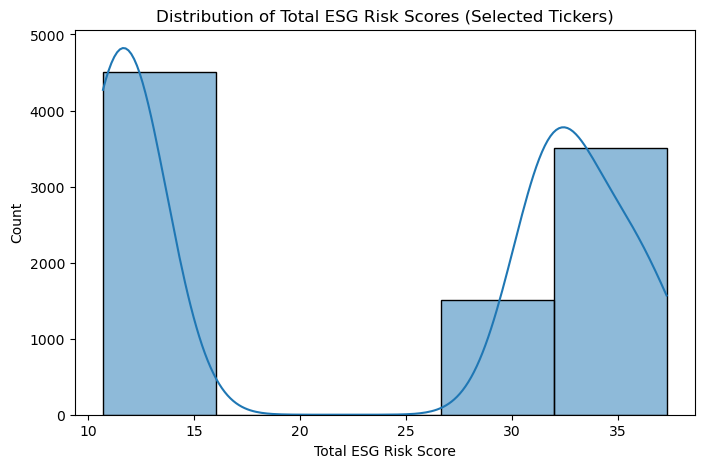

In [15]:
#distribution of total esg risk scores
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Total ESG Risk score'], kde=True, bins=5)
plt.title('Distribution of Total ESG Risk Scores (Selected Tickers)')
plt.xlabel('Total ESG Risk Score')
plt.show()

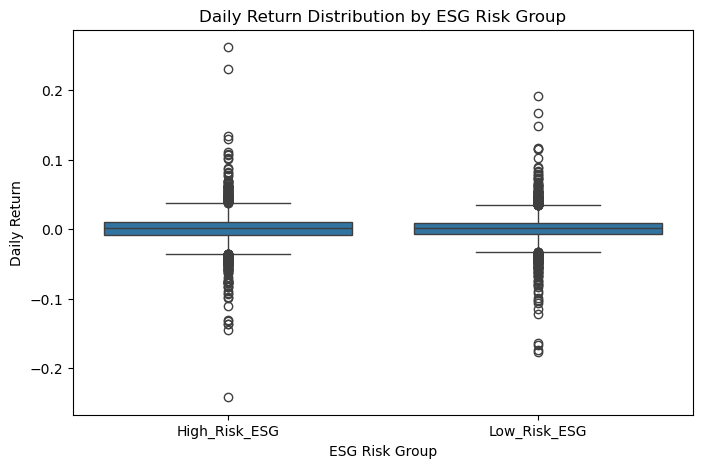

In [16]:
#box plot shows return distribution by esg risk group
plt.figure(figsize=(8, 5))
sns.boxplot(x='Risk_Group', y='Return', data=df_clean)
plt.title('Daily Return Distribution by ESG Risk Group')
plt.xlabel('ESG Risk Group')
plt.ylabel('Daily Return')
plt.show()

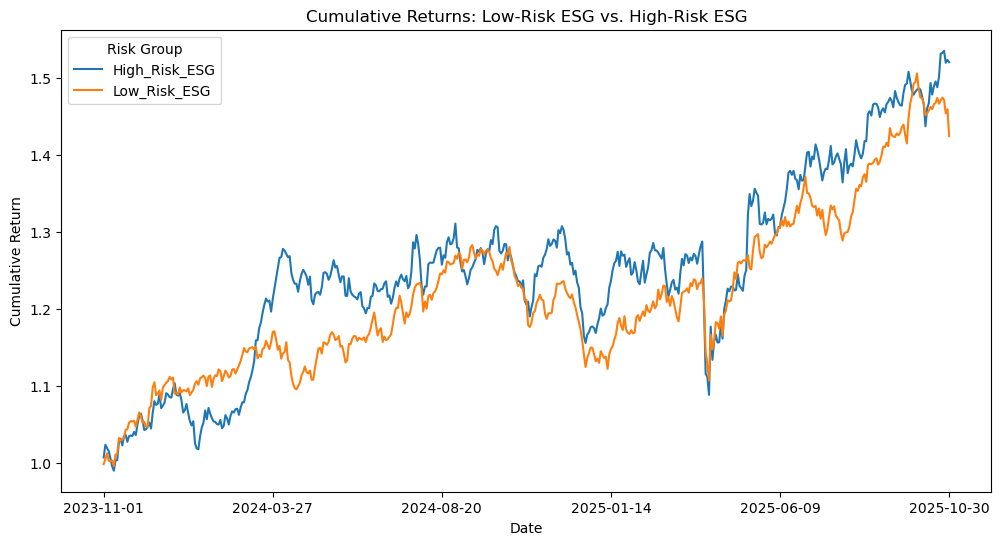

In [17]:
#plot time series cumulative returns by risk group
cumulative_returns = (1 + df_clean.groupby(['Date', 'Risk_Group'])['Return'].mean()).unstack()
cumulative_returns = cumulative_returns.cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns: Low-Risk ESG vs. High-Risk ESG')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Risk Group')
plt.show()

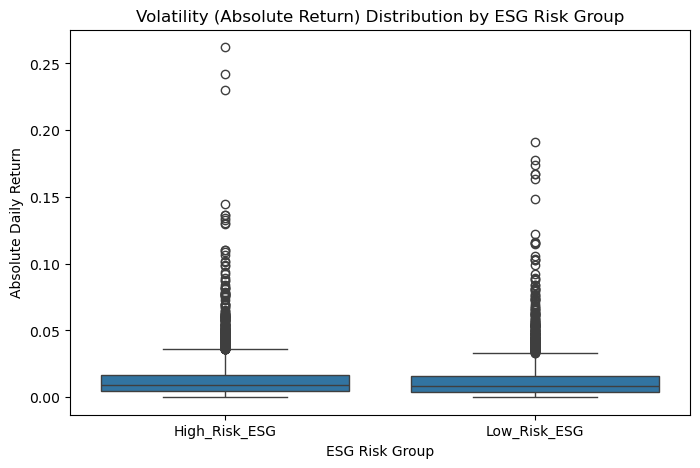

In [18]:
#box plot of volatility which is absolute return risk group
df_clean['Abs_Return'] = df_clean['Return'].abs()
plt.figure(figsize=(8, 5))
sns.boxplot(x='Risk_Group', y='Abs_Return', data=df_clean)
plt.title('Volatility (Absolute Return) Distribution by ESG Risk Group')
plt.xlabel('ESG Risk Group')
plt.ylabel('Absolute Daily Return')
plt.show()

## Simple Linear Regression Model

In [20]:
X = df_clean[['Total ESG Risk score', 'Open', 'High', 'Low', 'Volume']]
y = df_clean['Return']

# train-test split. shuffle=false bc time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False 
)

#initiaise lr model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#model eval
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Linear Regression Model Results:
Mean Squared Error (MSE): 0.00022789802178266986
Root Mean Squared Error (RMSE): 0.015096291656650976


In [21]:
#model coeffs (feature importance)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Model Coefficients (Impact on Return):")
print(coefficients)

Model Coefficients (Impact on Return):
                Feature   Coefficient
3                   Low  4.185469e-03
2                  High  3.128970e-03
0  Total ESG Risk score  3.686417e-05
4                Volume -1.315595e-10
1                  Open -7.303740e-03


In [22]:
#rscore

### Using Prophet Model

### Preparing high and low esg risk ratings

Prophet cannot handle multiple stocks in one dataframe (it is designed to handle a single ds-y combination not multiple y's(Close values for different tickers) for a single ds)

Steps:
1. Create 2 dataframes by splitting into 3 quantiles(tertiles) then selecting the low and high group.
2. Calculate average closing price per day and assign it to y variable
3. Run 2 seperate models for each dataset


In [25]:
#split df
df['risk_group'] = pd.qcut(df['Total ESG Risk score'], q=3, labels=['Low', 'Mid', 'High'])

#ignore the mid
esg_low_risk = df[df['risk_group'] == 'Low']
esg_high_risk = df[df['risk_group'] == 'High']

#aggregate 
def create_index(df):
    #calculate avg closing price per day
    daily_avg = df.groupby('Date')['Close'].mean().reset_index()

    #rename to meet prophet requirements
    return daily_avg.rename(columns={'Date': 'ds', 'Close': 'y'})

#high and lower risk scores datasets for model input
high_risk_esg_prophet = create_index(esg_high_risk)
low_risk_esg_prophet = create_index(esg_low_risk)


In [26]:
high_risk_esg_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      502 non-null    object 
 1   y       502 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


In [27]:
def prophet(df, group_name):
    
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)#sort date values before splitting
    split_point = int(len(df) * 0.8)
    split_date = df.iloc[split_point]['ds'] #to ascertain the split date

    print(f"--- {group_name} Split Info ---")
    print(f"Total Data Points: {len(df)}")
    print(f"Training on first {split_point} days (Until {split_date.date()})")
    print(f"Testing on last {len(df) - split_point} days (The 20% Test Set)\n")

    train_df = df[df['ds'] <= split_date]
    test_df = df[df['ds'] > split_date]

    #model.fit
    m = Prophet()
    m.fit(train_df)

    #predict
    forecast = m.predict(test_df[['ds']])

    #metrics
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")

    return train_df, test_df, forecast, mae

In [28]:
#run models
train_h, test_h, preds_h, mae_h = prophet(high_risk_esg_prophet, "High Risk ESG")
train_l, test_l, preds_l, mae_l = prophet(low_risk_esg_prophet, "Low Risk ESG")

--- High Risk ESG Split Info ---
Total Data Points: 502
Training on first 401 days (Until 2025-06-09)
Testing on last 101 days (The 20% Test Set)



16:58:11 - cmdstanpy - INFO - Chain [1] start processing
16:58:11 - cmdstanpy - INFO - Chain [1] done processing
16:58:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.67
RMSE: 14.56

--- Low Risk ESG Split Info ---
Total Data Points: 502
Training on first 401 days (Until 2025-06-09)
Testing on last 101 days (The 20% Test Set)



16:58:11 - cmdstanpy - INFO - Chain [1] done processing


MAE: 10.61
RMSE: 12.50



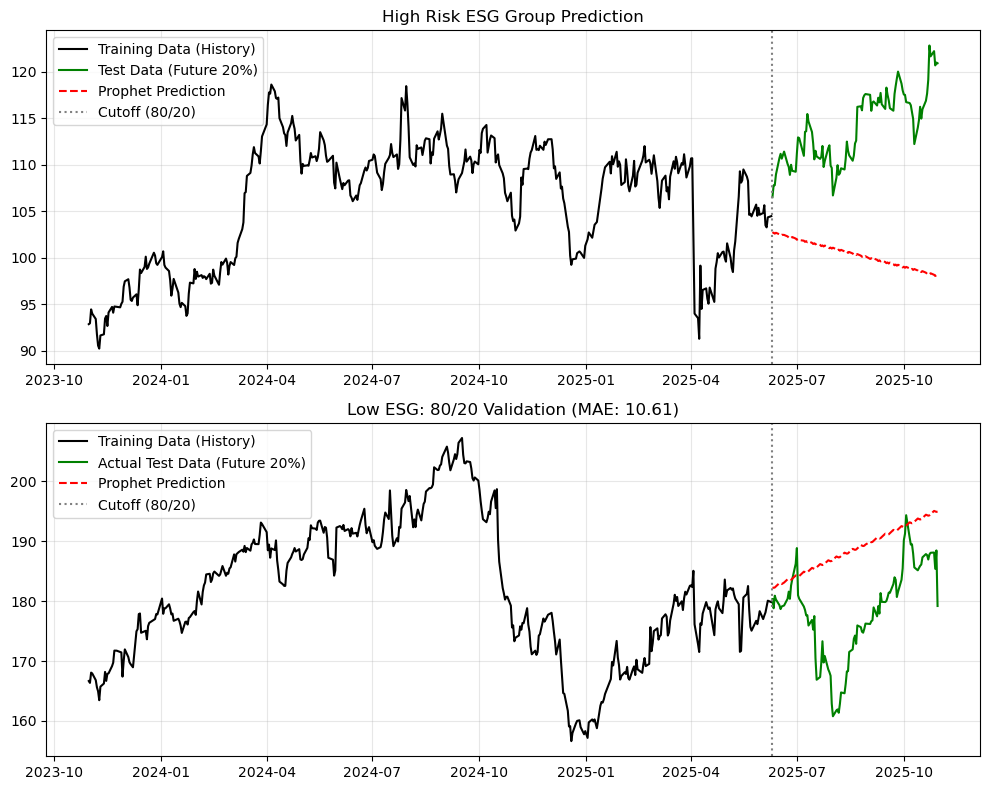

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#Plot high risk esg group
ax1.plot(train_h['ds'], train_h['y'], label='Training Data (History)', color='black')
ax1.plot(test_h['ds'], test_h['y'], label='Test Data (Future 20%)', color='green')
ax1.plot(test_h['ds'], preds_h['yhat'], label='Prophet Prediction', color='red', linestyle='--')
# Draw a vertical line where the split happened
ax1.axvline(x=test_h['ds'].iloc[0], color='gray', linestyle=':', label='Cutoff (80/20)')
ax1.set_title('High Risk ESG Group Prediction')
ax1.legend()
ax1.grid(True, alpha=0.3)

#Plot low risk esg group
ax2.plot(train_l['ds'], train_l['y'], label='Training Data (History)', color='black')
ax2.plot(test_l['ds'], test_l['y'], label='Actual Test Data (Future 20%)', color='green')
ax2.plot(test_l['ds'], preds_l['yhat'], label='Prophet Prediction', color='red', linestyle='--')
ax2.axvline(x=test_l['ds'].iloc[0], color='gray', linestyle=':', label='Cutoff (80/20)')
ax2.set_title(f'Low ESG: 80/20 Validation (MAE: {mae_l:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Using ARIMA

In [31]:
#import required libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [32]:
def prepare_arima_data(df):
    #daily avg close price
    daily_avg = df.groupby('Date')['Close'].mean()
    
    #Normalize start to 100
    #start_price = daily_avg.iloc[0]
    #normalized_series = (daily_avg / start_price) * 100
    
    #ensure index is datetime
    daily_avg.index = pd.to_datetime(daily_avg.index).to_period('D')
    
    # 4. Set Frequency (Optional but helps ARIMA avoid warnings)
    # 'B' = Business days, 'D' = Calendar days. 
    # If you have gaps (weekends), use .asfreq('D') to fill them or just leave as is.
    return daily_avg

In [33]:
series_high = prepare_arima_data(esg_high_risk)
series_low = prepare_arima_data(esg_low_risk)

In [34]:
def evaluate_arima(series, group_name):
    #train test split
    split_pt = int(len(series) * 0.8)
    
    train = series.iloc[:split_pt]
    test = series.iloc[split_pt:]
    
    print(f"--- {group_name} ---")
    print(f"Train Size: {len(train)} | Test Size: {len(test)}")
    
    #Train model: 5=Look back 1 week, 1=Difference once(trend), 0=Moving avg
    model = ARIMA(train, order=(5,1,0), trend='t')
    model_fit = model.fit()
    
    #Forecast/Predict
    forecast_result = model_fit.forecast(steps=len(test))
    
    #assign the correct dates to the forecast for plotting
    forecast_series = pd.Series(forecast_result.values, index=test.index)
    
    #model eval
    mae = mean_absolute_error(test, forecast_series)
    rmse = np.sqrt(mean_squared_error(test, forecast_series))
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")
    
    return train, test, forecast_series, mae, rmse


In [35]:
#model evaluation
print("Running ARIMA Evaluation...\n")

train_h, test_h, pred_h, mae_h, rmse_h = evaluate_arima(series_high, "High ESG Risk")
train_l, test_l, pred_l, mae_l, rmse_l = evaluate_arima(series_low, "Low ESG Risk")

Running ARIMA Evaluation...

--- High ESG Risk ---
Train Size: 401 | Test Size: 101
MAE: 7.78
RMSE: 8.44

--- Low ESG Risk ---
Train Size: 401 | Test Size: 101
MAE: 5.98
RMSE: 7.95



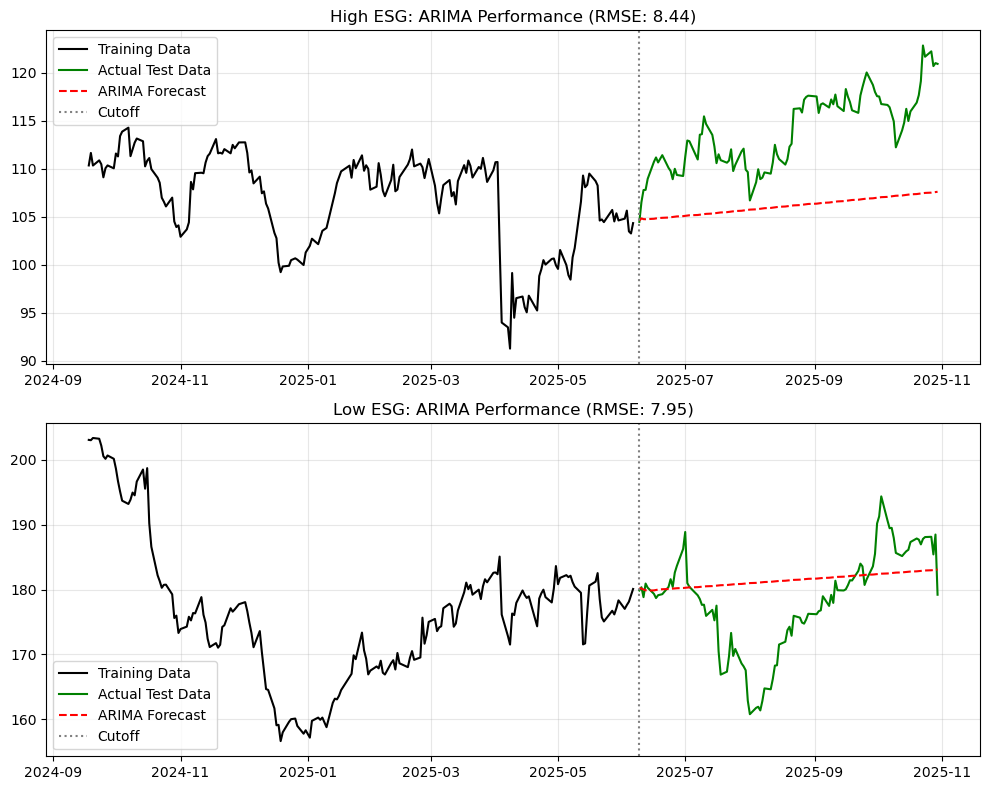

In [47]:
#visualise predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#convert dates to timestamp for plotting
def date_conversion(series):
    return series.index.to_timestamp()
    
train_h_dates = date_conversion(train_h)
test_h_dates = date_conversion(test_h)
pred_h_dates = date_conversion(pred_h)

#plot high risk esg group
ax1.plot(train_h_dates[-180:], train_h.values[-180:], label='Training Data', color='black')
ax1.plot(test_h_dates, test_h.values, label='Actual Test Data', color='green')
ax1.plot(pred_h_dates, pred_h.values, label='ARIMA Forecast', color='red', linestyle='--')
ax1.axvline(x=test_h_dates[0], color='gray', linestyle=':', label='Cutoff')
ax1.set_title(f'High ESG: ARIMA Performance (RMSE: {rmse_h:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

##plot low risk esg group
train_l_dates = date_conversion(train_l)
test_l_dates = date_conversion(test_l)
pred_l_dates = date_conversion(pred_l)

ax2.plot(train_l_dates[-180:], train_l.values[-180:], label='Training Data', color='black')
ax2.plot(test_l_dates, test_l.values, label='Actual Test Data', color='green')
ax2.plot(pred_l_dates, pred_l.values, label='ARIMA Forecast', color='red', linestyle='--')
ax2.axvline(x=test_l_dates[0], color='gray', linestyle=':', label='Cutoff')
ax2.set_title(f'Low ESG: ARIMA Performance (RMSE: {rmse_l:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()